
## Processing Sensor Data from Catalina Jemez CZO MC Pit 2
- Marc Berghouse 9/19/2020: original format
- Zach Perzan 9/23/2020: improved format and working PRISM concat

This array includes:
- apogee_SO110
- Vaisala_GMM220
- DecagonMPS2
- Decagon5TE
- Vertical Redox probes from Paleo Terra

Issues:
- Not sure what CO2 data is usable
- I'm not sure which water potential values are unrealistic
- Looks like reduction potential spikes should be dropped

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

def plot_cols(column_list, ylabel=''):
    """Plot columns from df. Columns to plot must be in
    column_list."""
    
    n = len(column_list)

    fig, ax = plt.subplots(n, figsize=(10,3*n), tight_layout=True, sharex=True)

    for i, col in enumerate(column_list):
        ax[i].plot(df.index, df[col], label=col)
        ax[i].legend(loc='upper right')
        ax[i].set(ylabel=ylabel)
        
    return fig, ax

In [2]:
# Import each file individually as a dataframe and append it to a list of dataframes

infiles = ["../../raw_data/Catalina-Jemez/MC_Pit2/mc_pit2_2010.csv", 
           "../../raw_data/Catalina-Jemez/MC_Pit2/mc_pit2_2011.csv", 
           "../../raw_data/Catalina-Jemez/MC_Pit2/mc_pit2_2012.csv", 
           "../../raw_data/Catalina-Jemez/MC_Pit2/mc_pit2_2013.csv", 
           "../../raw_data/Catalina-Jemez/MC_Pit2/mc_pit2_2014.csv", 
           "../../raw_data/Catalina-Jemez/MC_Pit2/mc_pit2_2015.csv", 
           "../../raw_data/Catalina-Jemez/MC_Pit2/mc_pit2_2016.csv", 
           "../../raw_data/Catalina-Jemez/MC_Pit2/mc_pit2_2017.csv", 
           "../../raw_data/Catalina-Jemez/MC_Pit2/mc_pit2_2018.csv",
           "../../raw_data/Catalina-Jemez/MC_Pit2/MC2co2o2_2013.csv",  
           "../../raw_data/Catalina-Jemez/MC_Pit2/MC2co2o2_2014.csv",  
           "../../raw_data/Catalina-Jemez/MC_Pit2/MC2co2o2_2015.csv",  
           "../../raw_data/Catalina-Jemez/MC_Pit2/MC2co2o2_2016.csv",  
           "../../raw_data/Catalina-Jemez/MC_Pit2/MC2co2o2_2017.csv", 
           "../../raw_data/Catalina-Jemez/MC_Pit2/Redox_MC_Pit2_2014.csv", 
           "../../raw_data/Catalina-Jemez/MC_Pit2/Redox_MC_Pit2_2015.csv", 
           "../../raw_data/Catalina-Jemez/MC_Pit2/Redox_MC_Pit2_2016.csv", 
           "../../raw_data/Catalina-Jemez/MC_Pit2/Redox_MC_Pit2_2017.csv", 
           "../../raw_data/Catalina-Jemez/MC_Pit2/Redox_MC_Pit2_2018.csv"]

# Lists of all dataframes
df_list = []

for infile in tqdm(infiles):
    df = pd.read_csv(infile, na_values=['NAN', -9999],  parse_dates=[0], 
                     index_col=0, skiprows=[1]) # skiprows=[1] skips the 1th row (0-indexed)
    df_list.append(df)
    
prism_path = "../../raw_data/Catalina-Jemez/Catalina-Jemez_MC_PRISM.csv"
ppt = pd.read_csv(prism_path, na_values=['NAN',-9999,-99999], skiprows=11, 
                  parse_dates=[0], index_col=0, names=['PRISM_precip.mm']) 
ppt['PRISM_precip.mm'] = pd.to_numeric(ppt['PRISM_precip.mm'])

In [3]:
columns = ['SoilMoisture_9.5cm.m3m3', 'Decagon5TETemp_9.5cm.deg.C', 
           'BulkEC_9.5cm.dS/m','SoilMoisture_44cm.m3m3', 'Decagon5TETemp_44cm.deg.C', 
           'BulkEC_44cm.dS/m','SoilMoisture_65cm.m3m3', 'Decagon5TETemp_65cm.deg.C', 
           'BulkEC_65cm.dS/m', 'Voltage_11cm.mV', 'Voltage_44cm.mV', 
           'ApogeeTemp_2cm.deg.C','ApogeeTemp_10cm.deg.C', 'ApogeeTemp_30cm.deg.C', 
           'ApogeeTemp_60cm.deg.C', 'O2_2cm.percent.0-100', 'O2_10cm.percent.0-100', 
           'O2_30cm.percent.0-100', 'O2_60cm.percent.0-100', 'CO2_2cm.ppm', 
           'CO2_10cm.ppm', 'CO2_30cm.ppm', 'CO2_60cm.ppm', 'ReductionPotential_5cm.mV',
           'ReductionPotential_10cm.mV','ReductionPotential_30cm.mV',
           'ReductionPotential_60cm.mV']

# Concatenate all individual files to a single dataframe
df = pd.concat(df_list)
df.columns = columns

# Resample everything to hourly averages since certain 
# sensors are measured on different schedules
df.sort_index(inplace=True) # Sort first
df = df.resample('1H').mean()
df
# Add on up-sampled PRISM data
# (resample daily to hourly, using the nearest value, then
#  add on as new column to df)
hourly_ppt = ppt.resample('1H').nearest()
df.loc[hourly_ppt.index, 'PRISM_precip.mm'] = hourly_ppt['PRISM_precip.mm']

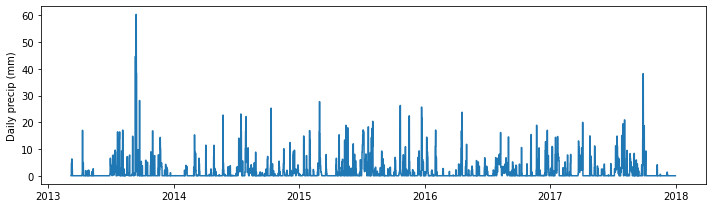

In [4]:
# Plot precip data
fig, ax = plt.subplots(figsize=(10,3), tight_layout=True)

ax.plot(df.index, df['PRISM_precip.mm'])
ax.set(ylabel='Daily precip (mm)');

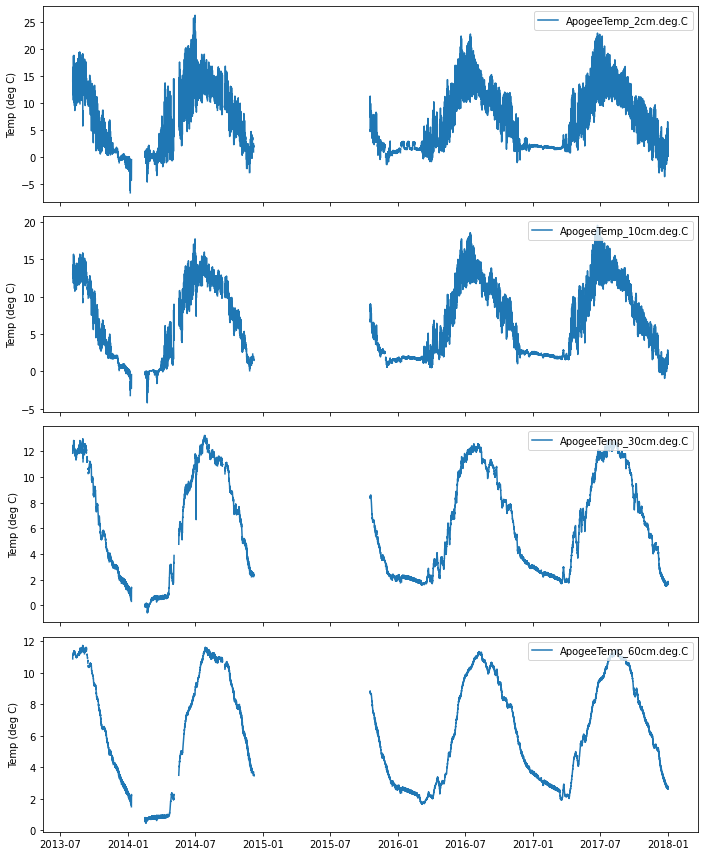

In [5]:
# Plot apogee thermistor temperature
apogee_temp_cols = [col for col in df.columns if 'ApogeeTemp' in col]
plot_cols(apogee_temp_cols, ylabel='Temp (deg C)');

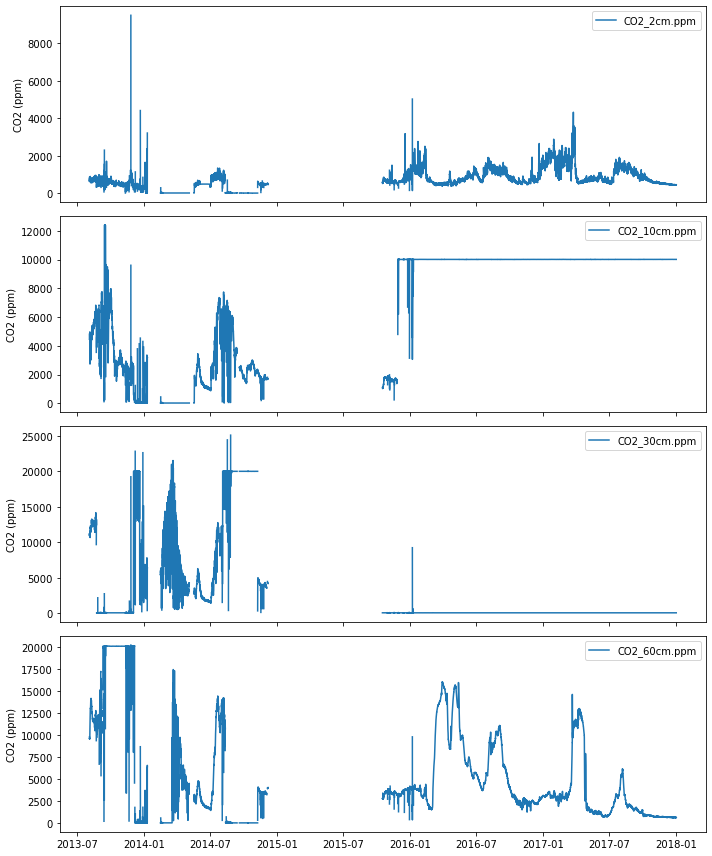

In [6]:
# Plot CO2 data
# Not sure what data is usable here
co2_cols = [col for col in df.columns if 'CO2' in col]
plot_cols(co2_cols, ylabel='CO2 (ppm)');

In [7]:
df['CO2_2cm.ppm']=df['CO2_2cm.ppm'].loc['2015-07-01':]
df['CO2_60cm.ppm']=df['CO2_60cm.ppm'].loc['2015-07-01':]
df=df.drop(columns='CO2_10cm.ppm')
df=df.drop(columns='CO2_30cm.ppm')

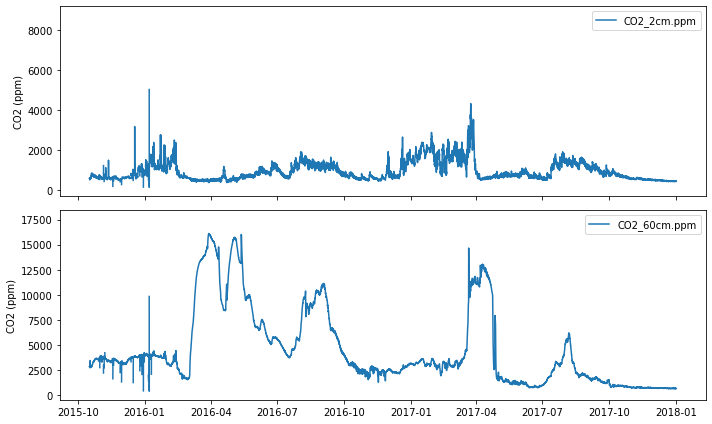

In [8]:
co2_cols = [col for col in df.columns if 'CO2' in col]
plot_cols(co2_cols, ylabel='CO2 (ppm)');

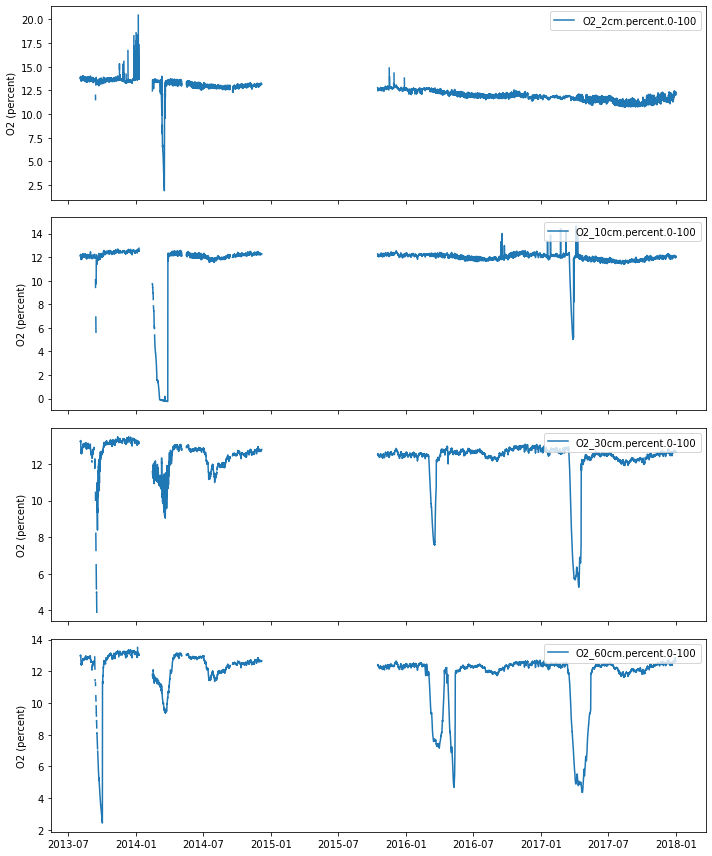

In [9]:
# Plot O2 data
o2_cols = [col for col in df.columns if col[:2] == 'O2']
plot_cols(o2_cols, ylabel='O2 (percent)');

In [10]:
df['O2_2cm.percent.0-100']=df['O2_2cm.percent.0-100'].loc['2015-07-01':]
df['O2_60cm.percent.0-100']=df['O2_60cm.percent.0-100'].loc['2015-07-01':]
df=df.drop(columns='O2_10cm.percent.0-100')
df=df.drop(columns='O2_30cm.percent.0-100')

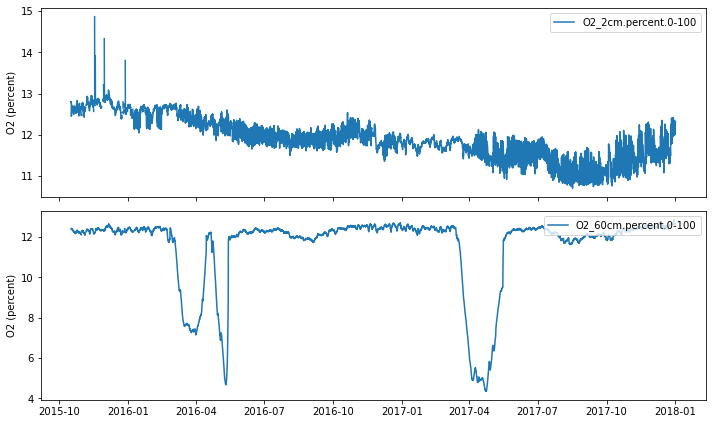

In [11]:
# Plot corrected O2 data
o2_cols = [col for col in df.columns if col[:2] == 'O2']
plot_cols(o2_cols, ylabel='O2 (percent)');

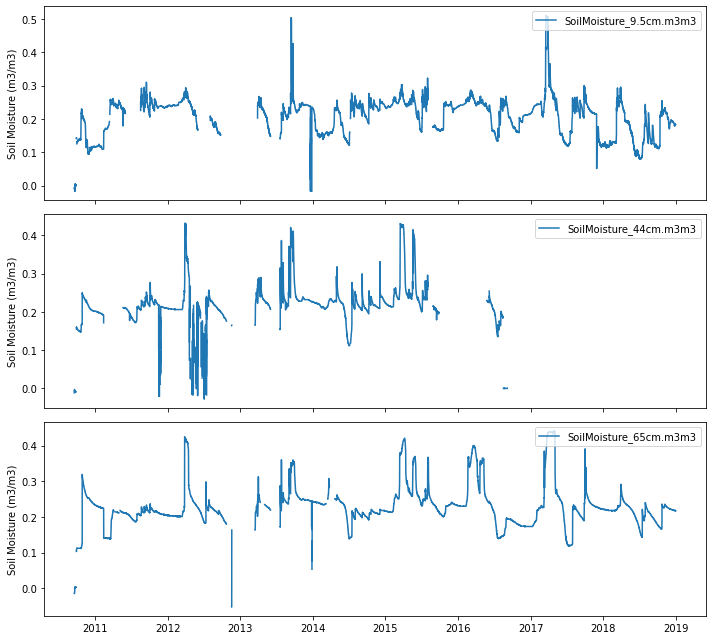

In [12]:
# Plot soil moisture data
sm_cols = [col for col in df.columns if 'SoilMoisture' in col]
plot_cols(sm_cols, ylabel='Soil Moisture (m3/m3)');

In [13]:
df['SoilMoisture_9.5cm.m3m3']=df['SoilMoisture_9.5cm.m3m3'].loc['2015-10-01':'2018-01-01']
df['SoilMoisture_65cm.m3m3']=df['SoilMoisture_65cm.m3m3'].loc['2015-10-01':'2018-01-01']
df=df.drop(columns='SoilMoisture_44cm.m3m3')

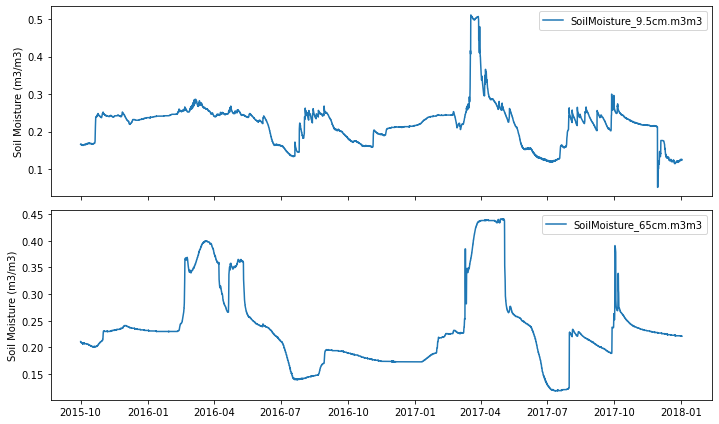

In [14]:
sm_cols = [col for col in df.columns if 'SoilMoisture' in col]
plot_cols(sm_cols, ylabel='Soil Moisture (m3/m3)');

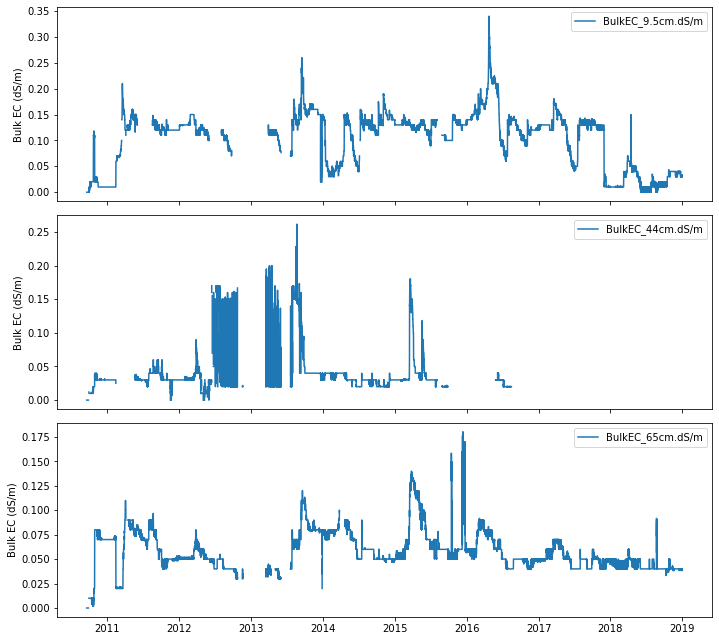

In [15]:
# Plot bulk EC
ec_cols = [col for col in df.columns if 'BulkEC' in col]
plot_cols(ec_cols, ylabel='Bulk EC (dS/m)');

In [16]:
df['BulkEC_9.5cm.dS/m']=df['BulkEC_9.5cm.dS/m'].loc['2015-10-01':'2018-01-01']
df['BulkEC_65cm.dS/m']=df['BulkEC_65cm.dS/m'].loc['2015-10-01':'2018-01-01']
df=df.drop(columns='BulkEC_44cm.dS/m')

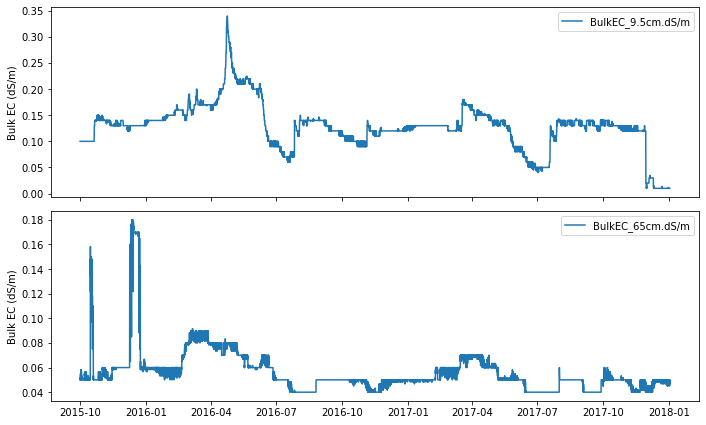

In [17]:
# Plot corrected bulk EC
ec_cols = [col for col in df.columns if 'BulkEC' in col]
plot_cols(ec_cols, ylabel='Bulk EC (dS/m)');

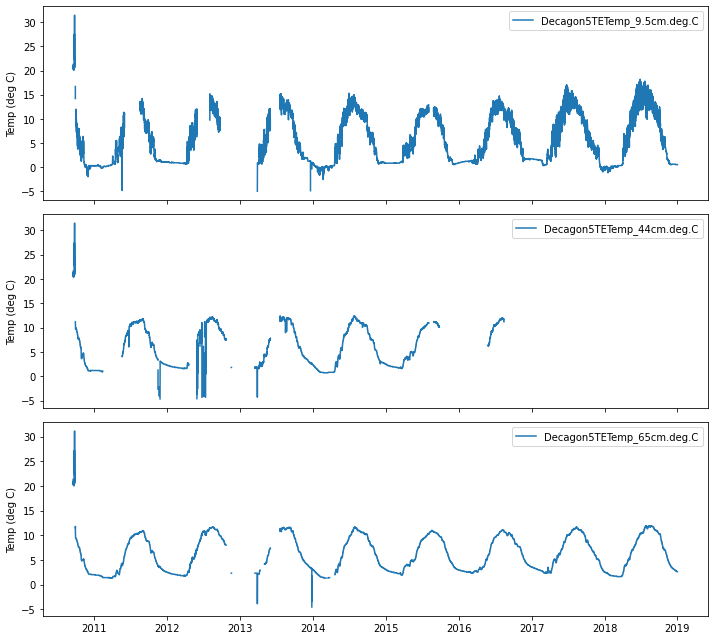

In [18]:
# Plot soil temperature from Decagon 5TE
dec_temp_cols = [col for col in df.columns if 'Decagon5TETemp' in col]

# There are several erroneous values less than -5 deg C
for col in dec_temp_cols:
    df[df[col] < -5] = np.nan
plot_cols(dec_temp_cols, ylabel='Temp (deg C)');

In [19]:
df=df.drop(columns='Decagon5TETemp_9.5cm.deg.C')
df=df.drop(columns='Decagon5TETemp_44cm.deg.C')
df=df.drop(columns='Decagon5TETemp_65cm.deg.C')
df=df.drop(columns='Voltage_11cm.mV')
df=df.drop(columns='Voltage_44cm.mV')

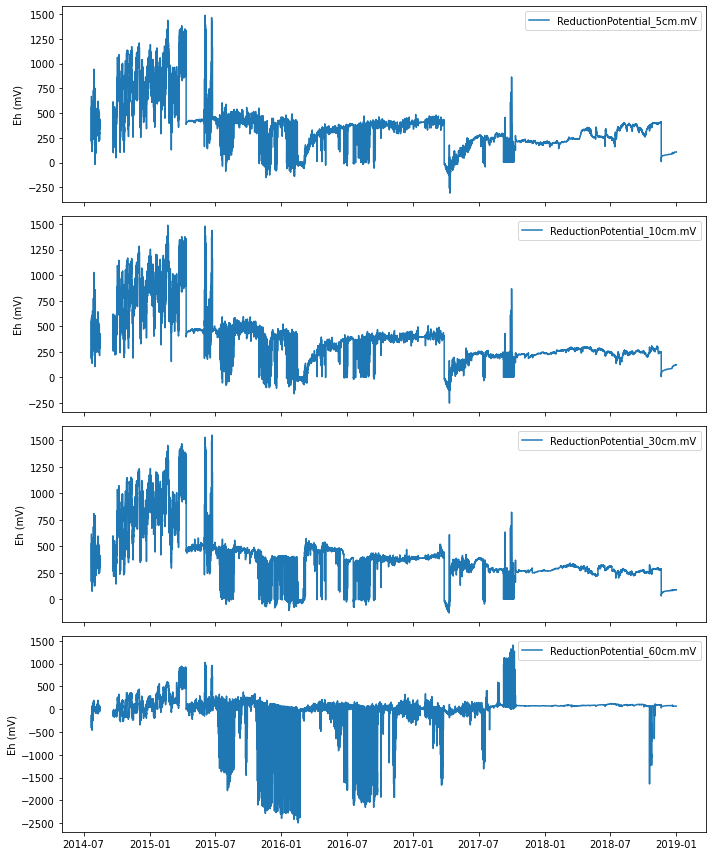

In [20]:
# Plot redox potential
eh_cols = [col for col in df.columns if 'ReductionPotential' in col]
plot_cols(eh_cols, ylabel='Eh (mV)');

In [21]:
# I couldn't find any literature suggesting values below -1000 are reasonable 
# (PaleoTerra says values of -600 are reasonable for water of pH>9)
df['ReductionPotential_5cm.mV']=df['ReductionPotential_5cm.mV'].loc['2015-10-01':'2018-01-01']
df['ReductionPotential_60cm.mV']=df['ReductionPotential_60cm.mV'].loc['2015-10-01':'2018-01-01']
df=df.drop(columns='ReductionPotential_10cm.mV')
df=df.drop(columns='ReductionPotential_30cm.mV')
df['ReductionPotential_60cm.mV'].mask(df['ReductionPotential_60cm.mV']<=-1000, inplace=True)

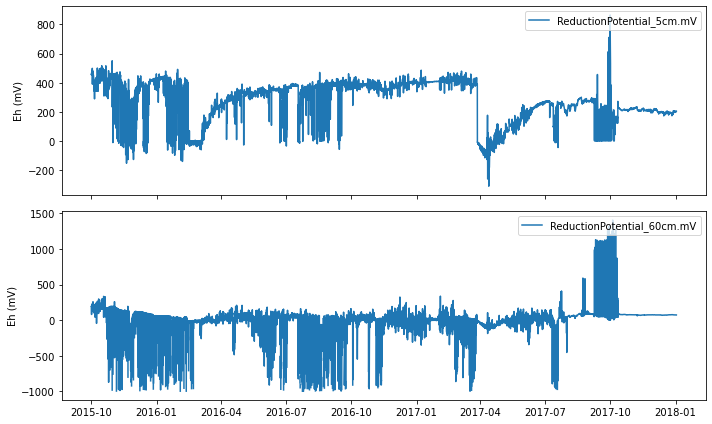

In [22]:
# Plot corrected redox potential
eh_cols = [col for col in df.columns if 'ReductionPotential' in col]
plot_cols(eh_cols, ylabel='Eh (mV)');

In [23]:
#Since the merge code returns values for each unique depth, and we are assuming that depths can be approximated up to + or - 8cm,
#Here I rename the exact depths with approximate depths that correspond to the exact CO2 depths
df['SoilMoisture_10cm.m3m3']=df['SoilMoisture_9.5cm.m3m3']
df=df.drop(columns='SoilMoisture_9.5cm.m3m3')

df['SoilMoisture_60cm.m3m3']=df['SoilMoisture_65cm.m3m3']
df=df.drop(columns='SoilMoisture_65cm.m3m3')
df['BulkEC_10cm.dS/m']=df['BulkEC_9.5cm.dS/m']
df=df.drop(columns='BulkEC_9.5cm.dS/m')

df['BulkEC_60cm.dS/m']=df['BulkEC_65cm.dS/m']
df=df.drop(columns='BulkEC_65cm.dS/m')
df['ReductionPotential_2cm.mV']=df['ReductionPotential_5cm.mV']
df=df.drop(columns='ReductionPotential_5cm.mV')

In [26]:
SM_nan_index=df['CO2_2cm.ppm'][df['CO2_2cm.ppm'].notna()==False]
SM_not_nan_index=df['CO2_2cm.ppm'][df['CO2_2cm.ppm'].notna()==True]

print (len(SM_nan_index))
print (len(SM_not_nan_index))
print(len(SM_nan_index)/(len(SM_nan_index)+len(SM_not_nan_index)))

mask = df['CO2_2cm.ppm'].isna()
d_SM = df.index.to_series()[mask].groupby((~mask).cumsum()[mask]).agg(['first', 'size'])
d_SM.rename(columns=dict(size='num of contig null', first='Start_Date')).reset_index(drop=True)


CO2_nan_index=df['CO2_60cm.ppm'][df['CO2_60cm.ppm'].notna()==False]
CO2_not_nan_index=df['CO2_60cm.ppm'][df['CO2_60cm.ppm'].notna()==True]

print (len(CO2_nan_index))
print (len(CO2_not_nan_index))
print(len(CO2_nan_index)/(len(CO2_nan_index)+len(CO2_not_nan_index)))

mask = df['CO2_60cm.ppm'].isna()
d_CO2 = df.index.to_series()[mask].groupby((~mask).cumsum()[mask]).agg(['first', 'size'])
d_CO2.rename(columns=dict(size='num of contig null', first='Start_Date')).reset_index(drop=True)


print (np.mean(d_CO2['size']))
print (np.std(d_CO2['size']))

53692
18965
0.7389790384959467
53692
18965
0.7389790384959467
1491.4444444444443
7415.758751336552


In [24]:
output=df.copy()
outfile = '../../processed_data/Catalina-Jemez/MC2_processed.csv'
output.to_csv(outfile, na_rep=-99999, index_label='DateTime.MST')

In [25]:
output

,ApogeeTemp_2cm.deg.C,ApogeeTemp_10cm.deg.C,ApogeeTemp_30cm.deg.C,ApogeeTemp_60cm.deg.C,O2_2cm.percent.0-100,O2_60cm.percent.0-100,CO2_2cm.ppm,CO2_60cm.ppm,ReductionPotential_60cm.mV,PRISM_precip.mm,SoilMoisture_10cm.m3m3,SoilMoisture_60cm.m3m3,BulkEC_10cm.dS/m,BulkEC_60cm.dS/m,ReductionPotential_2cm.mV
2010-09-17 15:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-09-17 16:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-09-17 17:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-09-17 18:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-09-17 19:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 19:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-12-31 20:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-12-31 21:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-12-31 22:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
